10000개의 학습 이미지 불러오기
학습 데이터 다 불러옴
데이터 나누기 완
knn 모델 훈련 완

검증 세트 정확도: 29.05%
              precision    recall  f1-score   support

    airplane       0.32      0.45      0.37       194
  automobile       0.47      0.16      0.24       196
        bird       0.19      0.36      0.25       206
         cat       0.21      0.11      0.14       205
        deer       0.20      0.50      0.29       187
         dog       0.41      0.19      0.26       203
        frog       0.22      0.21      0.22       199
       horse       0.57      0.18      0.27       199
        ship       0.40      0.63      0.49       203
       truck       0.60      0.14      0.23       208

    accuracy                           0.29      2000
   macro avg       0.36      0.29      0.28      2000
weighted avg       0.36      0.29      0.28      2000

k = 3 | 평균 정확도: 0.2713, 점수: [0.259375 0.27375  0.281875 0.28     0.26125 ]
k = 5 | 평균 정확도: 0.2791, 점수: [0.2725   0.28     0.280625 0.291875 0.270625]
k = 7 | 평균 정확도: 0

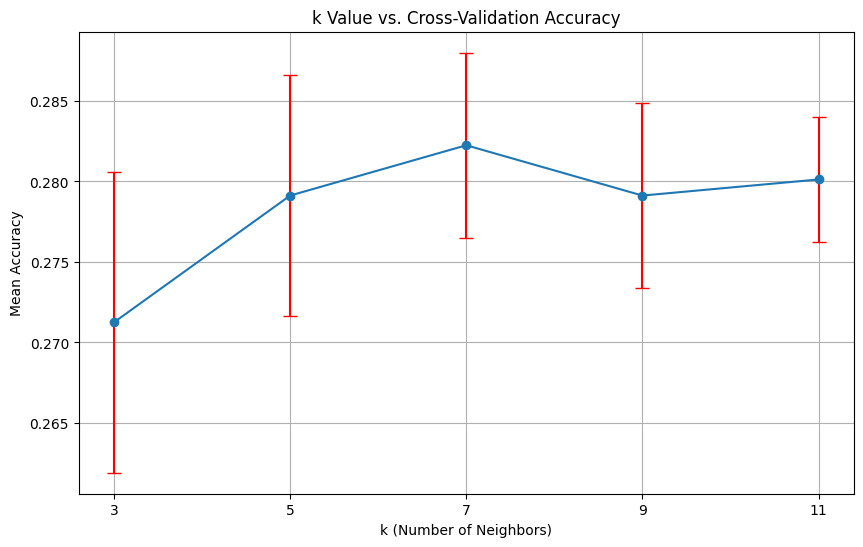

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score


train_labels_df = pd.read_csv('cifar-10/trainLabels.csv')
train_dir = 'cifar-10/train/train'
test_dir = 'cifar-10/test/test'

n_samples = 10000 #to reduce runtime
train_labels_df = train_labels_df.sample(n=n_samples, random_state=42)

X_list = [] #image data
y_list = [] #label data

print(f"{len(train_labels_df)}개의 학습 이미지 불러오기")
for index, row in train_labels_df.iterrows():
    img_path = os.path.join(train_dir, f"{row['id']}.png")
    image = cv2.imread(img_path)
    if image is not None:
        X_list.append(image.flatten())
        y_list.append(row['label'])

X = np.array(X_list)
y = np.array(y_list)
print("학습 데이터 다 불러옴")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #divide train/validation
print("데이터 나누기 완")

#KNN 모델 훈련 시작
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1) #n_neighbors는 홀수odd여야 함
knn.fit(X_train, y_train)
print("knn 모델 훈련 완")

#검증 데이터 사용
y_pred_val = knn.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)

print(f"\n검증 세트 정확도: {accuracy * 100:.2f}%")
print(classification_report(y_val, y_pred_val))

#5-fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
k_values_to_test = [3, 5, 7, 9, 11] #테스트해볼 k값들
mean_accuracies = []
std_accuracies = []
results = {}

for k in k_values_to_test:
    knn_cv = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    scores = cross_val_score(knn_cv, X_train, y_train, cv=kfold, scoring='accuracy')
    results[k] = scores
    mean_accuracies.append(np.mean(scores))
    std_accuracies.append(np.std(scores))
    print(f"k = {k} | 평균 정확도: {np.mean(scores):.4f}, 점수: {scores}")

best_k = max(results, key=lambda k: np.mean(results[k]))
print(f"\n교차 검증 결과, 최적의 k값 : {best_k} (평균 정확도: {np.mean(results[best_k]):.4f}).")

#figure
plt.figure(figsize=(10, 6))
plt.errorbar(k_values_to_test, mean_accuracies, yerr=std_accuracies, marker='o', linestyle='-', capsize=5, ecolor='red')
plt.title('k Value vs. Cross-Validation Accuracy')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Accuracy')
plt.xticks(k_values_to_test)
plt.grid(True)
plt.savefig('knn_cv_performance.png')
print("'knn_cv_performance.png' 파일이 저장되었습니다.")
print("-" * 50)

#best k - knn model
final_knn_model = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
final_knn_model.fit(X, y)

submission_df = pd.read_csv('cifar-10/sampleSubmission.csv')
X_test_list = []
test_ids = []

for img_id in submission_df['id']:
    img_path = os.path.join(test_dir, f"{img_id}.png")
    image = cv2.imread(img_path)
    if image is not None:
        X_test_list.append(image.flatten())
        test_ids.append(img_id)

X_test = np.array(X_test_list)
predictions = final_knn_model.predict(X_test)

# 4. 제출 파일 생성
my_submission = pd.DataFrame({'id': test_ids, 'label': predictions})
my_submission.to_csv('my_submission.csv', index=False)
print("\n'my_submission.csv' 파일 생성이 완료되었습니다.")
print(my_submission.head())